# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

### Contents:
- [Background](#Background)
- [Data](#Data)
- [Building own model](#Building-own-model)
- [Evaluate results](#Evaluate-results)



In [1]:
# Import libraries here
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Average, Input, Activation, Reshape, TimeDistributed
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
pd.options.mode.chained_assignment = None  # default='warn'



**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):** 
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports. 
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* valdation set: consists of 120 MRI images from coronal, sagittal and transverse planes


## Data import

**import data and get labels**

In [2]:
train_path = '../data/train/'
valid_path = '../data/valid/'

In [3]:
datasets = {'train': train_path, 'valid': valid_path}
planes = ['axial', 'coronal', 'sagittal']
# diagnosis = ['abnormal','meniscus','acl']

In [4]:
def get_data(dataset_type, plane, diagnosis):
    # for eg, (train, sagittal, acl)
    if dataset_type == 'train':
        go = train_path
    else:
        go = valid_path
        
#     img_path = glob(f'{go}/{plane}/*.npy')
    plane_dir = f'{go}/{plane}'
    data = os.listdir(plane_dir)
    
    label_path = f'../data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, plane_dir, label_data)

**abnormal dataset**

In [5]:
# training data
train_coronal_data, train_coronal_dir, train_ab_label = get_data('train', 'coronal', 'abnormal')
train_axial_data, train_axial_dir, train_ab_label = get_data('train', 'axial', 'abnormal')
train_sagittal_data, train_sagittal_dir, train_ab_label = get_data('train', 'sagittal', 'abnormal')

In [6]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_ab_label = get_data('valid','coronal','abnormal')
valid_axial_data, valid_axial_dir, valid_ab_label = get_data('valid','axial','abnormal')
valid_sagittal_data, valid_sagittal_dir, valid_ab_label = get_data('valid','sagittal','abnormal')

**meniscus dataset**

In [7]:
# training data
train_coronal_data, train_coronal_dir, train_men_label = get_data('train', 'coronal', 'meniscus')
train_axial_data, train_axial_dir, train_men_label = get_data('train', 'axial', 'meniscus')
train_sagittal_data, train_sagittal_dir, train_men_label = get_data('train', 'sagittal', 'meniscus')

In [8]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_men_label = get_data('valid','coronal','meniscus')
valid_axial_data, valid_axial_dir, valid_men_label = get_data('valid','axial','meniscus')
valid_sagittal_data, valid_sagittal_dir, valid_men_label = get_data('valid','sagittal','meniscus')

In [9]:
train_coronal_data[0]

'0000.npy'

In [10]:
train_coronal_dir

'../data/train//coronal'

**acl dataset**

In [11]:
# training data
train_coronal_data, train_coronal_dir, train_acl_label = get_data('train', 'coronal', 'acl')
train_axial_data, train_axial_dir, train_acl_label = get_data('train', 'axial', 'acl')
train_sagittal_data, train_sagittal_dir, train_acl_label = get_data('train', 'sagittal', 'acl')

In [12]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_acl_label = get_data('valid','coronal','acl')
valid_axial_data, valid_axial_dir, valid_acl_label = get_data('valid','axial','acl')
valid_sagittal_data, valid_sagittal_dir, valid_acl_label = get_data('valid','sagittal','acl')

The dataset contains *s* x 256 x 256 images. Since middle images are the most useful, only 3 middle slides in the series are retained. 


In [13]:
def image_extraction(data, path, new_path): #3 images
    '''this function extracts middle 3 slides of each scan'''
    extract=[]
    new_data=[]
    for i in range(len(data)): 
        img = np.load(os.path.join(path,data[i]))
        middle_idx = int(img.shape[0]/2)
#         print(img.shape[0],middle_idx)
        img = img[(middle_idx - 1) : (middle_idx + 2)]
#         # reshape adapted for model (s x 256 x 256 x 1)
#         img_reshape = np.repeat(img[..., np.newaxis], 1, -1)
        img = img.reshape(256,256,3)
        extract.extend(img)
        new_data.append(np.array(extract))        
        extract.clear()
        
#     new_data.shape(1130,256,256,3) for train
    np.save(new_path, np.array(new_data))


Note that training data for all diagnoses are the same. Only labels are different.

**image extraction for training data**

In [14]:
# image extraction for 3 planes
new_path = '../data/train_transform/coronal'
image_extraction(train_coronal_data, train_coronal_dir, new_path)

In [15]:
new_path = '../data/train_transform/axial'
image_extraction(train_axial_data, train_axial_dir, new_path)

In [16]:
new_path = '../data/train_transform/sagittal'
image_extraction(train_sagittal_data, train_sagittal_dir, new_path)

In [17]:
image = np.load('../data/train_transform/sagittal.npy')

In [18]:
image[0].shape

(256, 256, 3)

**extraction for validation data**

In [19]:
# image extraction for 3 planes
new_path = '../data/valid_transform/coronal'
image_extraction(valid_coronal_data, valid_coronal_dir, new_path)

In [20]:
new_path = '../data/valid_transform/axial'
image_extraction(valid_axial_data, valid_axial_dir, new_path)

In [21]:
new_path = '../data/valid_transform/sagittal'
image_extraction(valid_sagittal_data, valid_sagittal_dir, new_path)

In [22]:
image = np.load('../data/valid_transform/sagittal.npy')
image.shape

(120, 256, 256, 3)

**data generation from extracted/transformed dataset**

In [23]:
def data_gen(dataset_type, plane, diagnosis):
    # for eg, (train, sagittal, mensicus)
    if dataset_type == 'train':
        go = '../data/train_transform/'
    else:
        go = '../data/valid_transform/'
        
    plane_dir = f'{go}/{plane}.npy'
    data = np.load(plane_dir)
    
    label_path = f'../data/{dataset_type}-{diagnosis}.csv'
#     label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, label_data)
    

Note that training data for all diagnoses are the same. Only labels are different. But for ease as inputs into model, data generation was done for planes and all diagnoses.

In [24]:
# meniscus
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal', 'meniscus')
axial_mensicus, axial_mensicus_label = data_gen('train', 'axial', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal', 'meniscus')

# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal', 'meniscus')
axial_mensicus_val, axial_mensicus_label_val  = data_gen('valid', 'axial', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal', 'meniscus')

In [25]:
# abnormal
# generate training input
coronal_abnormal, coronal_abnormal_label = data_gen('train', 'coronal', 'abnormal')
axial_abnormal, axial_abnormal_label = data_gen('train', 'axial', 'abnormal')
sagittal_abnormal, sagittal_abnormal_label = data_gen('train', 'sagittal', 'abnormal')

# generate validation
coronal_abnormal_val, coronal_abnormal_label_val  = data_gen('valid', 'coronal', 'abnormal')
axial_abnormal_val, axial_abnormal_label_val  = data_gen('valid', 'axial', 'abnormal')
sagittal_abnormal_val, sagittal_abnormal_label_val  = data_gen('valid', 'sagittal', 'abnormal')

In [26]:
# acl
# generate training input
coronal_acl, coronal_acl_label = data_gen('train', 'coronal', 'acl')
axial_acl, axial_acl_label = data_gen('train', 'axial', 'acl')
sagittal_acl, sagittal_acl_label = data_gen('train', 'sagittal', 'acl')

# generate validation
coronal_acl_val, coronal_acl_label_val  = data_gen('valid', 'coronal', 'acl')
axial_acl_val, axial_acl_label_val  = data_gen('valid', 'axial', 'acl')
sagittal_acl_val, sagittal_acl_label_val  = data_gen('valid', 'sagittal', 'acl')

## Building own model

The code snippet below is the first model, a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers. This is very similar to the architectures that Yann LeCun built in the 1990s for image classification (with the exception of ReLU)([LeCun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)). In addition, two fully-connected layers were added, and end with a single unit and a sigmoid activation, which is perfect for a binary classification. 
<br>
<br> Another reason why this was chosen as the first CNN, was because it can even be run on a CPU. 

In [27]:
def build_model():
    model = Sequential()
    
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3),
                     activation='relu',
                     padding='same',
                     input_shape=(256,256,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     activation='relu',
                     padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     activation='relu',
                     padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    
    sgd = optimizers.SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [28]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0

In [29]:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# training model that will be added to VGG16
def model_train(model, model_name, num_epochs, train_data, train_labels, validation_data, validation_labels):
    path_dir = r'C:\Users\USER\DSI-roughpaper\capstone\data' 
    path = f'{path_dir}\{model_name}\own_weights.h5'

    history = model.fit(x=train_data, y=np.array(train_labels), 
            batch_size=32, 
            validation_data=(validation_data, np.array(validation_labels)),
            epochs=num_epochs, 
            callbacks = [EarlyStopping(patience=5, monitor = 'val_loss', mode = 'min')],
            verbose=1)

    model.save_weights(path)
    
    return model, history

In [30]:
def plot_results(model):
    train_loss = model.history['loss']
    test_loss = model.history['val_loss']
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    epoch_labels = model.epoch

    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

    axes[0].plot(train_loss, label='Training Loss', color='#185fad')
    axes[0].plot(test_loss, label='Testing Loss', color='orange')

    axes[1].plot(acc, label='Training accuracy', color='blue')
    axes[1].plot(val_acc, label='Testing accuracy', color='red')

    # Set title
    axes[0].title.set_text('Training and Testing Loss by Epoch')
    axes[1].title.set_text('Training and Testing Accuracy by Epoch')
    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')
    axes[0].set_ylabel('Binary Crossentropy')
    axes[1].set_ylabel('Binary Crossentropy')
    plt.xticks(epoch_labels, epoch_labels);    
    axes[0].legend(fontsize=18);
    axes[1].legend(fontsize=18);


**predictions for abnormal dataset**

Epoch 1/20
36/36 [==============================] - 65s 2s/step - loss: 3.6079 - accuracy: 0.7531 - val_loss: 0.5480 - val_accuracy: 0.8000
Epoch 2/20
36/36 [==============================] - 75s 2s/step - loss: 0.4356 - accuracy: 0.8204 - val_loss: 0.4912 - val_accuracy: 0.8083
Epoch 3/20
36/36 [==============================] - 78s 2s/step - loss: 0.4131 - accuracy: 0.8124 - val_loss: 0.5158 - val_accuracy: 0.7917
Epoch 4/20
36/36 [==============================] - 82s 2s/step - loss: 0.3957 - accuracy: 0.8345 - val_loss: 0.5149 - val_accuracy: 0.8083
Epoch 5/20
36/36 [==============================] - 79s 2s/step - loss: 0.3851 - accuracy: 0.8336 - val_loss: 0.5094 - val_accuracy: 0.7917
Epoch 6/20
36/36 [==============================] - 84s 2s/step - loss: 0.3658 - accuracy: 0.8407 - val_loss: 0.5080 - val_accuracy: 0.7917
Epoch 7/20
36/36 [==============================] - 88s 2s/step - loss: 0.3639 - accuracy: 0.8381 - val_loss: 0.5204 - val_accuracy: 0.8083


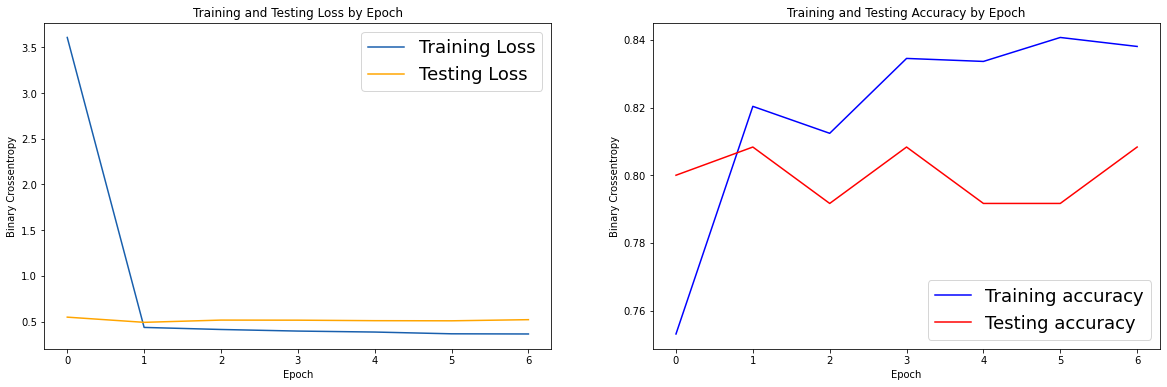

In [31]:
# coronal plane
num_epochs=20

cnn_model = build_model()
cor_ab_model, hst_cab = model_train(cnn_model, 'hst_cab', num_epochs, coronal_abnormal, coronal_abnormal_label, coronal_abnormal_val, coronal_abnormal_label_val)

# get/plot accuracy
hst_cab_acc=[]
hst_cab_acc.append(np.mean(hst_cab.history['val_accuracy']))
plot_results(hst_cab)

Epoch 1/20
36/36 [==============================] - 88s 2s/step - loss: 8.1945 - accuracy: 0.7434 - val_loss: 0.4780 - val_accuracy: 0.8000
Epoch 2/20
36/36 [==============================] - 78s 2s/step - loss: 0.4348 - accuracy: 0.8071 - val_loss: 0.4650 - val_accuracy: 0.8000
Epoch 3/20
36/36 [==============================] - 78s 2s/step - loss: 0.4149 - accuracy: 0.8142 - val_loss: 0.4641 - val_accuracy: 0.8000
Epoch 4/20
36/36 [==============================] - 79s 2s/step - loss: 0.3927 - accuracy: 0.8150 - val_loss: 0.4405 - val_accuracy: 0.8250
Epoch 5/20
36/36 [==============================] - 78s 2s/step - loss: 0.3834 - accuracy: 0.8336 - val_loss: 0.4515 - val_accuracy: 0.8000
Epoch 6/20
36/36 [==============================] - 79s 2s/step - loss: 0.3640 - accuracy: 0.8345 - val_loss: 0.4291 - val_accuracy: 0.8167
Epoch 7/20
36/36 [==============================] - 87s 2s/step - loss: 0.3652 - accuracy: 0.8389 - val_loss: 0.4192 - val_accuracy: 0.8583
Epoch 8/20
36/36 [==

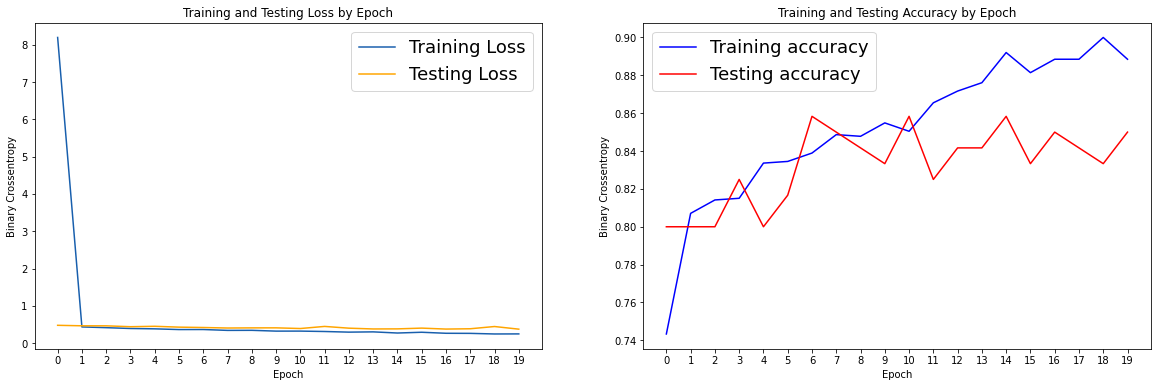

In [32]:
# axial plane
num_epochs=20

cnn_model = build_model()
axl_ab_model, hst_aab = model_train(cnn_model, 'hst_aab', num_epochs, axial_abnormal, axial_abnormal_label, axial_abnormal_val, axial_abnormal_label_val)

# get/plot accuracy
hst_aab_acc=[]
hst_aab_acc.append(np.mean(hst_aab.history['val_accuracy']))
plot_results(hst_aab)

Epoch 1/20
36/36 [==============================] - 63s 2s/step - loss: 5.9597 - accuracy: 0.7619 - val_loss: 0.4654 - val_accuracy: 0.7750
Epoch 2/20
36/36 [==============================] - 60s 2s/step - loss: 0.4147 - accuracy: 0.8230 - val_loss: 0.4452 - val_accuracy: 0.8083
Epoch 3/20
36/36 [==============================] - 60s 2s/step - loss: 0.3782 - accuracy: 0.8425 - val_loss: 0.4444 - val_accuracy: 0.8167
Epoch 4/20
36/36 [==============================] - 65s 2s/step - loss: 0.3764 - accuracy: 0.8319 - val_loss: 0.4495 - val_accuracy: 0.8167
Epoch 5/20
36/36 [==============================] - 61s 2s/step - loss: 0.3490 - accuracy: 0.8531 - val_loss: 0.4426 - val_accuracy: 0.8167
Epoch 6/20
36/36 [==============================] - 61s 2s/step - loss: 0.3423 - accuracy: 0.8407 - val_loss: 0.4071 - val_accuracy: 0.8167
Epoch 7/20
36/36 [==============================] - 59s 2s/step - loss: 0.3340 - accuracy: 0.8496 - val_loss: 0.4110 - val_accuracy: 0.8250
Epoch 8/20
36/36 [==

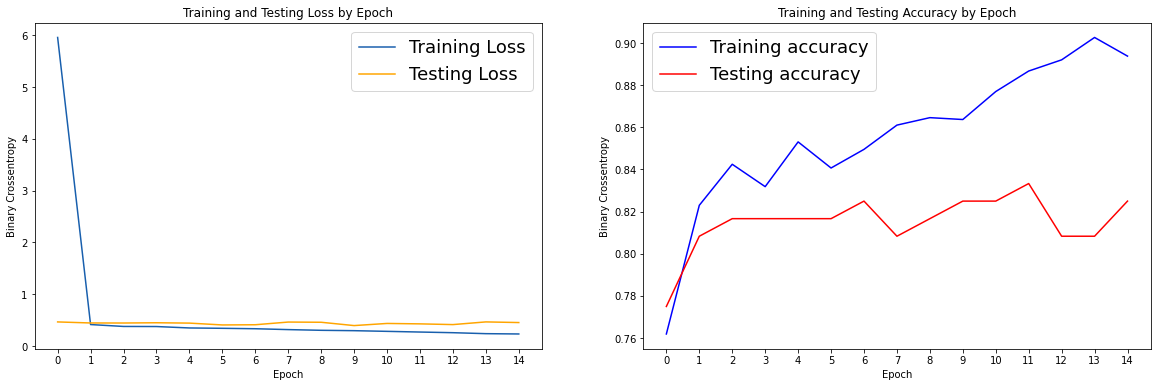

In [33]:
# sagittal plane
num_epochs=20

cnn_model = build_model()
sag_ab_model, hst_sab = model_train(cnn_model, 'hst_sab', num_epochs, sagittal_abnormal, sagittal_abnormal_label, sagittal_abnormal_val, sagittal_abnormal_label_val)

# get/plot accuracy
hst_sab_acc=[]
hst_sab_acc.append(np.mean(hst_sab.history['val_accuracy']))
plot_results(hst_sab)

**predictions for meniscus dataset**

Epoch 1/20
36/36 [==============================] - 74s 2s/step - loss: 2.4822 - accuracy: 0.5796 - val_loss: 0.7106 - val_accuracy: 0.5667
Epoch 2/20
36/36 [==============================] - 70s 2s/step - loss: 0.6172 - accuracy: 0.6451 - val_loss: 0.6659 - val_accuracy: 0.5667
Epoch 3/20
36/36 [==============================] - 60s 2s/step - loss: 0.5985 - accuracy: 0.6646 - val_loss: 0.6810 - val_accuracy: 0.5667
Epoch 4/20
36/36 [==============================] - 60s 2s/step - loss: 0.5797 - accuracy: 0.6805 - val_loss: 0.6624 - val_accuracy: 0.5667
Epoch 5/20
36/36 [==============================] - 59s 2s/step - loss: 0.5791 - accuracy: 0.6699 - val_loss: 0.6707 - val_accuracy: 0.5833
Epoch 6/20
36/36 [==============================] - 60s 2s/step - loss: 0.5499 - accuracy: 0.6982 - val_loss: 0.6728 - val_accuracy: 0.6083
Epoch 7/20
36/36 [==============================] - 60s 2s/step - loss: 0.5475 - accuracy: 0.7248 - val_loss: 0.6918 - val_accuracy: 0.5500
Epoch 8/20
36/36 [==

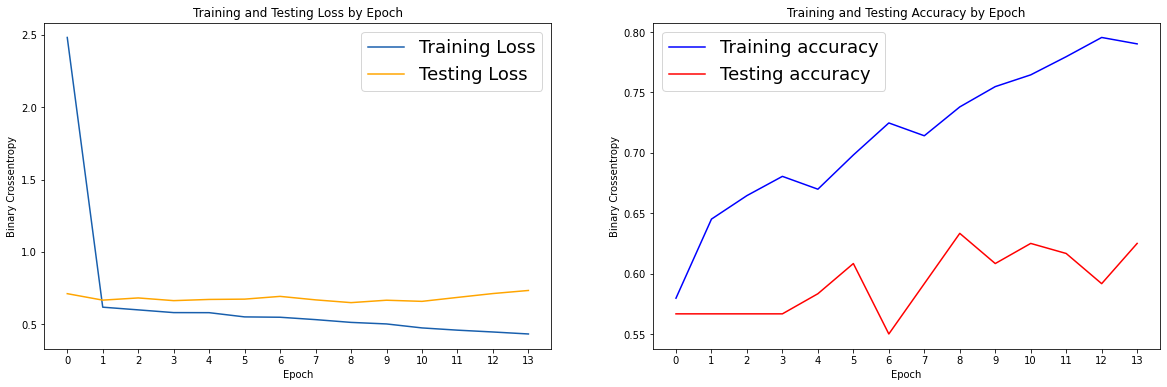

In [34]:
# coronal plane
num_epochs=20

cnn_model = build_model()
cor_men_model, hst_cmen = model_train(cnn_model, 'hst_cmen', num_epochs, coronal_mensicus, coronal_mensicus_label, coronal_mensicus_val, coronal_mensicus_label_val)

# get/plot accuracy
hst_cmen_acc=[]
hst_cmen_acc.append(np.mean(hst_cmen.history['val_accuracy']))
plot_results(hst_cmen)

Epoch 1/20
36/36 [==============================] - 60s 2s/step - loss: 7.4218 - accuracy: 0.6097 - val_loss: 0.6925 - val_accuracy: 0.5667
Epoch 2/20
36/36 [==============================] - 71s 2s/step - loss: 0.6290 - accuracy: 0.6637 - val_loss: 0.6448 - val_accuracy: 0.6000
Epoch 3/20
36/36 [==============================] - 77s 2s/step - loss: 0.6091 - accuracy: 0.6664 - val_loss: 0.6530 - val_accuracy: 0.5833
Epoch 4/20
36/36 [==============================] - 77s 2s/step - loss: 0.5911 - accuracy: 0.6885 - val_loss: 0.6466 - val_accuracy: 0.5750
Epoch 5/20
36/36 [==============================] - 68s 2s/step - loss: 0.5873 - accuracy: 0.6876 - val_loss: 0.6269 - val_accuracy: 0.6167
Epoch 6/20
36/36 [==============================] - 71s 2s/step - loss: 0.5622 - accuracy: 0.7027 - val_loss: 0.6206 - val_accuracy: 0.6833
Epoch 7/20
36/36 [==============================] - 68s 2s/step - loss: 0.5628 - accuracy: 0.6973 - val_loss: 0.6237 - val_accuracy: 0.6583
Epoch 8/20
36/36 [==

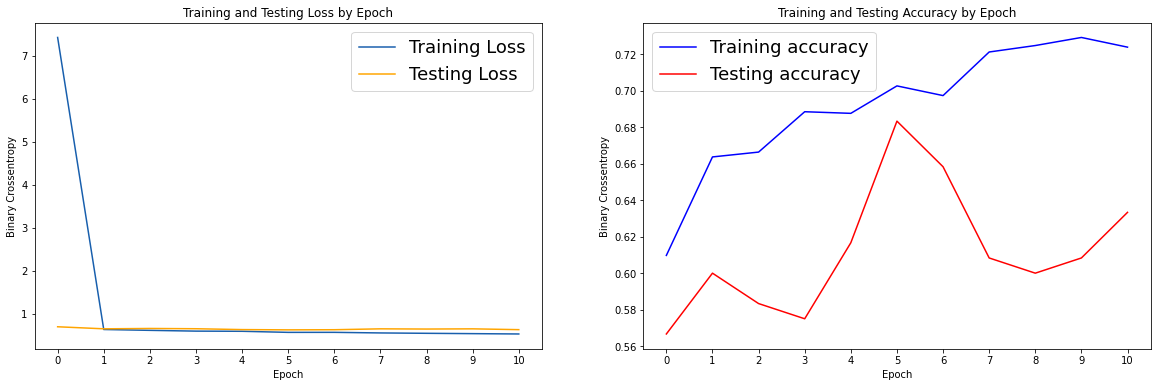

In [35]:
# axial plane
num_epochs=20

cnn_model = build_model()
axl_men_model, hst_amen = model_train(cnn_model, 'hst_amen', num_epochs, axial_mensicus, axial_mensicus_label, axial_mensicus_val, axial_mensicus_label_val)

# get/plot accuracy
hst_amen_acc=[]
hst_amen_acc.append(np.mean(hst_amen.history['val_accuracy']))
plot_results(hst_amen)

Epoch 1/20
36/36 [==============================] - 73s 2s/step - loss: 4.9808 - accuracy: 0.6115 - val_loss: 0.6715 - val_accuracy: 0.5917
Epoch 2/20
36/36 [==============================] - 62s 2s/step - loss: 0.6183 - accuracy: 0.6602 - val_loss: 0.6648 - val_accuracy: 0.5917
Epoch 3/20
36/36 [==============================] - 70s 2s/step - loss: 0.5876 - accuracy: 0.6788 - val_loss: 0.6229 - val_accuracy: 0.6417
Epoch 4/20
36/36 [==============================] - 69s 2s/step - loss: 0.5626 - accuracy: 0.7009 - val_loss: 0.6367 - val_accuracy: 0.6333
Epoch 5/20
36/36 [==============================] - 60s 2s/step - loss: 0.5504 - accuracy: 0.7159 - val_loss: 0.6456 - val_accuracy: 0.6417
Epoch 6/20
36/36 [==============================] - 68s 2s/step - loss: 0.5354 - accuracy: 0.7159 - val_loss: 0.6478 - val_accuracy: 0.6167
Epoch 7/20
36/36 [==============================] - 75s 2s/step - loss: 0.5092 - accuracy: 0.7434 - val_loss: 0.6050 - val_accuracy: 0.6583
Epoch 8/20
36/36 [==

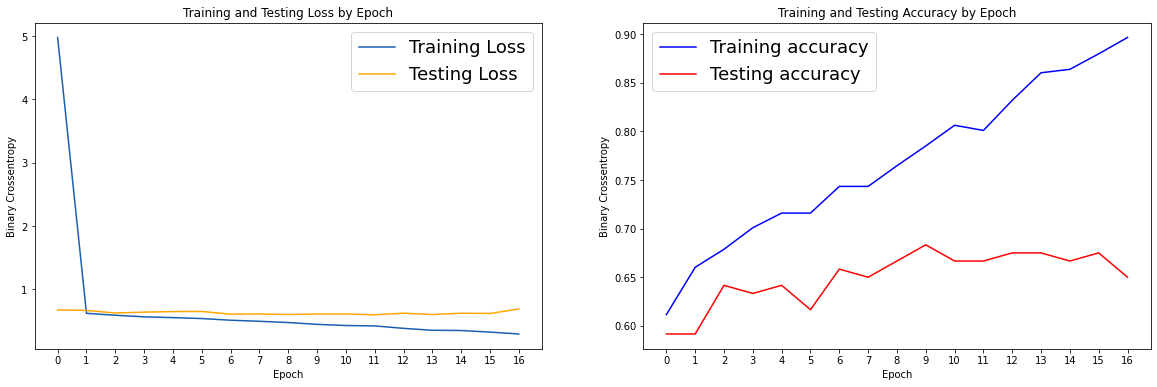

In [36]:
# sagittal plane
num_epochs=20

cnn_model = build_model()
sag_men_model, hst_smen = model_train(cnn_model, 'hst_smen', num_epochs, sagittal_mensicus, sagittal_mensicus_label, sagittal_mensicus_val, sagittal_mensicus_label_val)

# get/plot accuracy
hst_smen_acc=[]
hst_smen_acc.append(np.mean(hst_smen.history['val_accuracy']))
plot_results(hst_smen)

**predictions for acl dataset**

Epoch 1/20
36/36 [==============================] - 71s 2s/step - loss: 7.6773 - accuracy: 0.7531 - val_loss: 0.9617 - val_accuracy: 0.5500
Epoch 2/20
36/36 [==============================] - 71s 2s/step - loss: 0.4943 - accuracy: 0.8150 - val_loss: 0.8426 - val_accuracy: 0.5500
Epoch 3/20
36/36 [==============================] - 66s 2s/step - loss: 0.4866 - accuracy: 0.8159 - val_loss: 0.8331 - val_accuracy: 0.5500
Epoch 4/20
36/36 [==============================] - 77s 2s/step - loss: 0.4739 - accuracy: 0.8159 - val_loss: 0.8090 - val_accuracy: 0.5500
Epoch 5/20
36/36 [==============================] - 67s 2s/step - loss: 0.4629 - accuracy: 0.8150 - val_loss: 0.8492 - val_accuracy: 0.5500
Epoch 6/20
36/36 [==============================] - 64s 2s/step - loss: 0.4697 - accuracy: 0.8150 - val_loss: 0.8929 - val_accuracy: 0.5500
Epoch 7/20
36/36 [==============================] - 70s 2s/step - loss: 0.4591 - accuracy: 0.8159 - val_loss: 0.9731 - val_accuracy: 0.5500
Epoch 8/20
36/36 [==

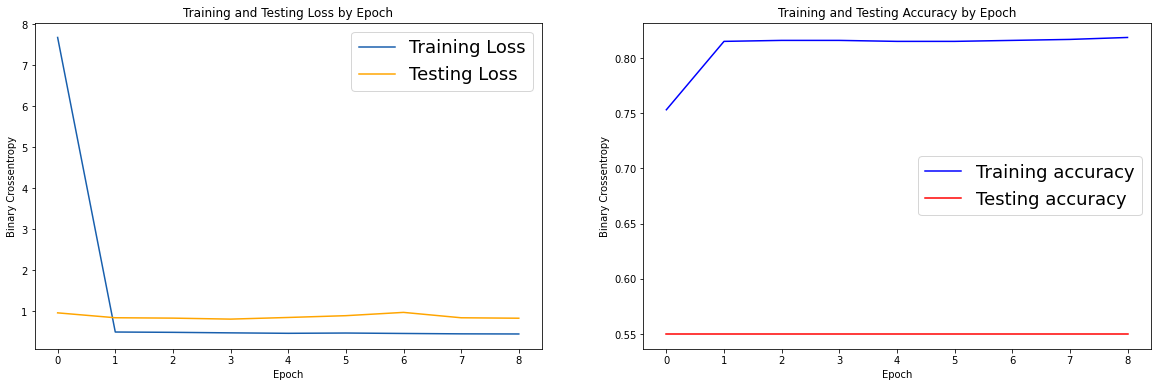

In [37]:
# coronal plane
num_epochs=20

cnn_model = build_model()
cor_acl_model, hst_cacl = model_train(cnn_model, 'hst_cacl', num_epochs, coronal_acl, coronal_acl_label, coronal_acl_val, coronal_acl_label_val)

# get/plot accuracy
hst_cacl_acc=[]
hst_cacl_acc.append(np.mean(hst_cacl.history['val_accuracy']))
plot_results(hst_cacl)

Epoch 1/20
36/36 [==============================] - 73s 2s/step - loss: 9.6040 - accuracy: 0.7407 - val_loss: 0.9793 - val_accuracy: 0.5500
Epoch 2/20
36/36 [==============================] - 71s 2s/step - loss: 0.4878 - accuracy: 0.8133 - val_loss: 0.8147 - val_accuracy: 0.5500
Epoch 3/20
36/36 [==============================] - 69s 2s/step - loss: 0.4699 - accuracy: 0.8150 - val_loss: 0.7878 - val_accuracy: 0.5500
Epoch 4/20
36/36 [==============================] - 69s 2s/step - loss: 0.4667 - accuracy: 0.8168 - val_loss: 0.7701 - val_accuracy: 0.5500
Epoch 5/20
36/36 [==============================] - 70s 2s/step - loss: 0.4532 - accuracy: 0.8177 - val_loss: 0.8721 - val_accuracy: 0.5500
Epoch 6/20
36/36 [==============================] - 70s 2s/step - loss: 0.4434 - accuracy: 0.8159 - val_loss: 0.9392 - val_accuracy: 0.5500
Epoch 7/20
36/36 [==============================] - 71s 2s/step - loss: 0.4323 - accuracy: 0.8168 - val_loss: 0.8806 - val_accuracy: 0.5500
Epoch 8/20
36/36 [==

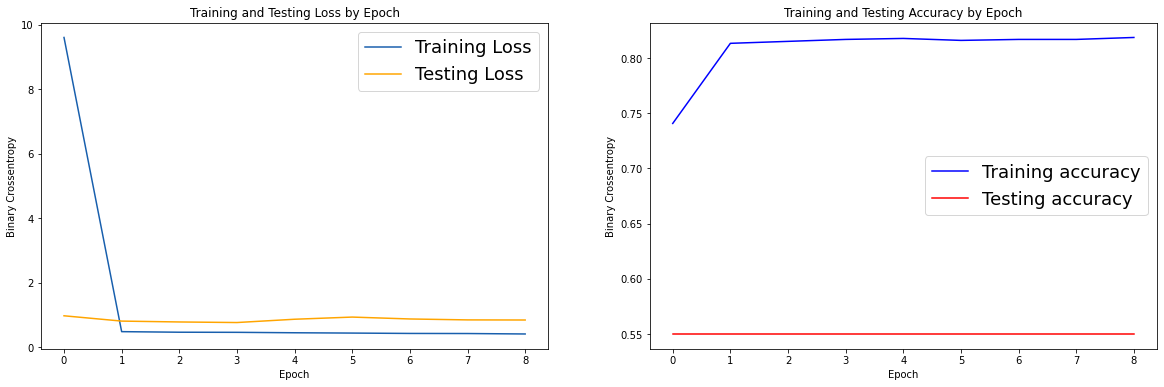

In [38]:
# axial plane
num_epochs=20

cnn_model = build_model()
axl_acl_model, hst_aacl = model_train(cnn_model, 'hst_aacl', num_epochs, axial_acl, axial_acl_label, axial_acl_val, axial_acl_label_val)

# get/plot accuracy
hst_aacl_acc=[]
hst_aacl_acc.append(np.mean(hst_aacl.history['val_accuracy']))
plot_results(hst_aacl)

Epoch 1/20
36/36 [==============================] - 73s 2s/step - loss: 13.6164 - accuracy: 0.7398 - val_loss: 0.7689 - val_accuracy: 0.5500
Epoch 2/20
36/36 [==============================] - 69s 2s/step - loss: 0.4713 - accuracy: 0.8142 - val_loss: 0.7717 - val_accuracy: 0.5500
Epoch 3/20
36/36 [==============================] - 70s 2s/step - loss: 0.4576 - accuracy: 0.8150 - val_loss: 0.8152 - val_accuracy: 0.5500
Epoch 4/20
36/36 [==============================] - 70s 2s/step - loss: 0.4462 - accuracy: 0.8239 - val_loss: 0.7483 - val_accuracy: 0.5667
Epoch 5/20
36/36 [==============================] - 64s 2s/step - loss: 0.4330 - accuracy: 0.8168 - val_loss: 0.7404 - val_accuracy: 0.5583
Epoch 6/20
36/36 [==============================] - 72s 2s/step - loss: 0.4220 - accuracy: 0.8177 - val_loss: 0.8192 - val_accuracy: 0.5500
Epoch 7/20
36/36 [==============================] - 69s 2s/step - loss: 0.4198 - accuracy: 0.8204 - val_loss: 0.6441 - val_accuracy: 0.6500
Epoch 8/20
36/36 [=

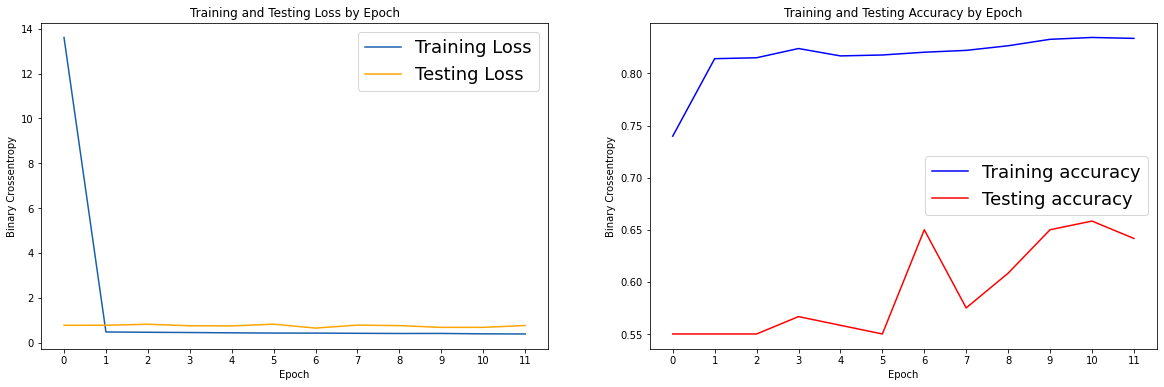

In [39]:
# sagittal plane
num_epochs=20

cnn_model = build_model()
sag_acl_model, hst_sacl = model_train(cnn_model, 'hst_sacl', num_epochs, sagittal_acl, sagittal_acl_label, sagittal_acl_val, sagittal_acl_label_val)

# get/plot accuracy
hst_sacl_acc=[]
hst_sacl_acc.append(np.mean(hst_sacl.history['val_accuracy']))
plot_results(hst_sacl)

**calculate average accuracy**

In [40]:
[hst_cmen_acc, hst_amen_acc, hst_smen_acc]

[[0.5928571394511631], [0.6121212189847772], [0.6500000007012311]]

In [41]:
[hst_cab_acc, hst_aab_acc, hst_sab_acc]

[[0.800000011920929], [0.8329166650772095], [0.8149999936421712]]

In [42]:
[hst_cacl_acc, hst_aacl_acc, hst_sacl_acc]

[[0.550000011920929], [0.550000011920929], [0.5923611124356588]]

## Evaluate results

### meniscus dataset

In [43]:
cmen_scores = cor_men_model.evaluate(coronal_mensicus_val, np.array(coronal_mensicus_label_val), verbose=0)
print('Test loss:', cmen_scores[0]) 
print('Test accuracy:', cmen_scores[1])

Test loss: 0.7327471375465393
Test accuracy: 0.625


In [44]:
amen_scores = axl_men_model.evaluate(axial_mensicus_val, np.array(axial_mensicus_label_val), verbose=0)
print('Test loss:', amen_scores[0]) 
print('Test accuracy:', amen_scores[1])

Test loss: 0.62538081407547
Test accuracy: 0.6333333253860474


In [45]:
smen_scores = sag_men_model.evaluate(sagittal_mensicus_val, np.array(sagittal_mensicus_label_val), verbose=0)
print('Test loss:', smen_scores[0]) 
print('Test accuracy:', smen_scores[1])

Test loss: 0.6860002875328064
Test accuracy: 0.6499999761581421


**Evaluate predictions**

In [46]:
cor_pred = cor_men_model.predict(coronal_mensicus_val) 
axl_pred = axl_men_model.predict(axial_mensicus_val) 
sag_pred = sag_men_model.predict(sagittal_mensicus_val) 


In [47]:
pred_men = pd.DataFrame(np.column_stack([cor_pred,axl_pred,sag_pred]),columns=['cor_pred', 'axl_pred', 'sag_pred'])
pred_men['mean'] = pred_men.mean(axis=1)

In [48]:
# since model output is [0,1] using sigmoid activation function
# pred is the probability
# take average probability from all 3 planes
pred_men['mean']

0      0.197942
1      0.117101
2      0.098765
3      0.040865
4      0.257267
         ...   
115    0.333669
116    0.446066
117    0.249611
118    0.368026
119    0.162843
Name: mean, Length: 120, dtype: float32

In [49]:
# if prob<0.5, it is 0.
pred_men['predict'] = pred_men['mean'].map(lambda x: 0 if x<0.5 else 1)

In [50]:
pred_men['predict'].value_counts()

0    97
1    23
Name: predict, dtype: int64

In [51]:
# labels are same for all planes
pred_men['true'] = coronal_mensicus_label_val

In [52]:
pred_men[pred_men['true'] != pred_men['predict']].shape

(41, 6)

In [53]:
pred_men[pred_men['true'] != pred_men['predict']]

,cor_pred,axl_pred,sag_pred,mean,predict,true
14,0.616908,0.661332,0.340698,0.539646,1,0
26,0.445696,0.529105,0.599213,0.524671,1,0
42,0.280822,0.252278,0.143841,0.225647,0,1
43,0.218989,0.485942,0.423618,0.376183,0,1
44,0.213246,0.393811,0.423770,0.343609,0,1
46,0.418754,0.504205,0.186578,0.369846,0,1
50,0.373836,0.618774,0.628572,0.540394,1,0
57,0.473298,0.745976,0.742518,0.653931,1,0
61,0.363350,0.660015,0.374560,0.465975,0,1
62,0.561679,0.654415,0.281923,0.499339,0,1


### abnormal dataset

In [54]:
cor_pred = cor_ab_model.predict(coronal_abnormal_val) 
axl_pred = axl_ab_model.predict(axial_abnormal_val) 
sag_pred = sag_ab_model.predict(sagittal_abnormal_val) 

pred_ab = pd.DataFrame(np.column_stack([cor_pred,axl_pred,sag_pred]),columns=['cor_pred', 'axl_pred', 'sag_pred'])
pred_ab['mean'] = pred_ab.mean(axis=1)

In [55]:
# since model output is [0,1] using sigmoid activation function
# pred is the probability
# take average probability from all 3 planes

# if prob<0.5, it is 0.
pred_ab['predict'] = pred_ab['mean'].map(lambda x: 0 if x<0.5 else 1)
pred_ab['predict'].value_counts()

1    114
0      6
Name: predict, dtype: int64

In [56]:
pred_ab['true'] = coronal_abnormal_label_val 
pred_ab[pred_ab['true'] != pred_ab['predict']].shape

(21, 6)

In [57]:
pred_ab[pred_ab['true'] != pred_ab['predict']]

,cor_pred,axl_pred,sag_pred,mean,predict,true
1,0.509992,0.513950,0.590722,0.538221,1,0
2,0.731799,0.292648,0.498567,0.507671,1,0
4,0.964196,0.659792,0.872240,0.832076,1,0
5,0.978889,0.909310,0.970588,0.952929,1,0
6,0.600311,0.750633,0.253340,0.534761,1,0
7,0.917007,0.549915,0.997573,0.821498,1,0
8,0.471805,0.626512,0.750757,0.616358,1,0
9,0.815044,0.491729,0.507998,0.604924,1,0
10,0.980249,0.995682,0.966148,0.980693,1,0
11,0.955295,0.751312,0.953252,0.886620,1,0


### acl dataset

In [58]:
cor_pred = cor_acl_model.predict(coronal_acl_val) 
axl_pred = axl_acl_model.predict(axial_acl_val) 
sag_pred = sag_acl_model.predict(sagittal_acl_val) 

pred_acl = pd.DataFrame(np.column_stack([cor_pred,axl_pred,sag_pred]),columns=['cor_pred', 'axl_pred', 'sag_pred'])
pred_acl['mean'] = pred_acl.mean(axis=1)

In [59]:
# if prob<0.5, it is 0.
pred_acl['predict'] = pred_acl['mean'].map(lambda x: 0 if x<0.5 else 1)
pred_acl['predict'].value_counts()

0    120
Name: predict, dtype: int64

In [60]:
pred_acl['true'] = coronal_acl_label_val 
pred_acl[pred_acl['true'] != pred_acl['predict']].shape

(54, 6)

In [61]:
pred_acl[pred_acl['true'] != pred_acl['predict']]

,cor_pred,axl_pred,sag_pred,mean,predict,true
42,0.104243,0.172289,0.101137,0.125890,0,1
43,0.187495,0.138359,0.139757,0.155204,0,1
44,0.214923,0.183419,0.560272,0.319538,0,1
45,0.105405,0.150933,0.578622,0.278320,0,1
46,0.164984,0.200779,0.440120,0.268628,0,1
47,0.179478,0.257712,0.426587,0.287925,0,1
48,0.140011,0.098169,0.194250,0.144143,0,1
49,0.232942,0.281489,0.373825,0.296085,0,1
51,0.148809,0.285647,0.152038,0.195498,0,1
52,0.158048,0.174553,0.543205,0.291935,0,1


**export results to csv**

In [62]:
pred_ab.to_csv('../data/own_pred_ab_results.csv')
pred_acl.to_csv('../data/own_pred_acl_results.csv')
pred_men.to_csv('../data/own_pred_men_results.csv')